In [130]:
from utils import load_buffers,load_task_markers
import pandas as pd
import config
import os
import numpy as np

import mne
from mne import create_info
from mne.epochs import EpochsArray
from mne.decoding import Vectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt
%matplotlib qt

In [152]:
# load the task and signal files stored in the disk
# Based on the task timestamps, subset the signals and annotate the events
# create epoch data that includes the signal and events
# use the epoch data to train a classifier
# save the classifier model as a pickle file for prediction later

# Load the .npz file for task
file_path = 'processed_data/motor_imagery/2024-06-03_22-57-05/task_data/task_markers.npz'  # Replace with your file path
df_tasks = load_task_markers(file_path)

# Load the .npz file for buffer
folder_path = 'processed_data/motor_imagery/2024-06-03_22-57-05/signal_data/'
df_buffers = load_buffers(folder_path)

# print(df_buffers)
print("Reading signals and markers from signals from disk...")

df_buffers = df_buffers.sort_values('timestamps').reset_index(drop=True)
df_tasks = df_tasks.sort_values('timestamps').reset_index(drop=True)

Array names in the .npz file: ['event_ids', 'timestamps']
Reading signals and markers from signals from disk...


In [153]:
df_buffers

,buffer_col_0,buffer_col_1,buffer_col_2,buffer_col_3,buffer_col_4,buffer_col_5,buffer_col_6,buffer_col_7,buffer_col_8,buffer_col_9,buffer_col_10,buffer_col_11,buffer_col_12,buffer_col_13,buffer_col_14,buffer_col_15,buffer_col_16,timestamps,part_number
0,186386.921875,167550.734375,171446.656250,187459.265625,183097.453125,164166.781250,166521.046875,161325.781250,0.055908,1.008545,-0.028564,-2.014160,0.335693,0.671387,73.333336,737439.0,1.0,798165.063115,1
1,186383.343750,167548.234375,171446.031250,187463.109375,183104.343750,164171.421875,166529.718750,161340.531250,0.056885,1.008301,-0.027588,-2.044677,0.274658,0.762939,73.333336,737440.0,1.0,798165.067223,1
2,186387.265625,167556.640625,171451.484375,187467.312500,183116.312500,164178.125000,166528.906250,161351.343750,0.057861,1.008545,-0.027588,-2.075195,0.091553,0.854492,73.333336,737441.0,1.0,798165.067238,1
3,186389.781250,167564.234375,171454.781250,187468.656250,183114.796875,164181.078125,166536.062500,161349.734375,0.058838,1.008057,-0.030762,-1.953125,0.061035,0.915527,73.333336,737442.0,1.0,798165.067245,1
4,186386.375000,167556.187500,171453.000000,187466.765625,183108.000000,164179.921875,166538.203125,161340.078125,0.057129,1.011230,-0.028564,-2.166748,0.061035,0.854492,73.333336,737443.0,1.0,798165.067251,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,186467.015625,167622.890625,171525.156250,187449.875000,183119.531250,164223.546875,166572.625000,161398.203125,0.050293,1.006348,-0.084717,-2.075195,-0.183105,0.701904,73.333336,741934.0,1.0,798182.988627,9
4496,186463.984375,167621.468750,171523.984375,187451.031250,183118.468750,164225.062500,166576.562500,161409.109375,0.049805,1.004883,-0.085938,-2.166748,-0.183105,0.762939,73.333336,741935.0,1.0,798182.990561,9
4497,186461.218750,167628.171875,171521.578125,187446.750000,183118.640625,164218.281250,166552.156250,161394.625000,0.049561,1.005371,-0.086914,-2.105713,-0.305176,0.793457,73.333336,741936.0,1.0,798182.992969,9
4498,186461.390625,167628.796875,171518.093750,187440.937500,183106.390625,164208.796875,166538.562500,161362.343750,0.047852,1.005615,-0.088135,-2.044677,-0.274658,0.946045,73.333336,741937.0,1.0,798182.996678,9


In [154]:
df_buffers_raw = df_buffers.iloc[:,:config.device_details['relevant_channels_from_device']] 
df_buffers_raw = df_buffers_raw * 1e-6

channel_names = config.device_details['channels']
df_buffers_raw.columns = channel_names

In [29]:
# df_buffers_raw

In [155]:
# df_buffers_raw
info = mne.create_info(
        ch_names=channel_names,
        sfreq=config.device_details['sfreq'],  # Assuming the data is sampled at 1 Hz; adjust as necessary
        # change this for different electrode configuration
        ch_types=['eeg'] * len(channel_names))

raw = mne.io.RawArray(df_buffers_raw[channel_names].values.T, info)
raw.info

Creating RawArray with float64 data, n_channels=8, n_times=4500
    Range : 0 ... 4499 =      0.000 ...    17.996 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [13]:
# raw.info[]

In [156]:
df_markers = df_tasks[df_tasks['event_ids'].isin([1,2,3,4,99,100])]

markers_map = {
            1 :'left_start',
            2: 'left_end',
            3:'right_start',
            4:'right_end',
            99:'rest_start',
            100:'rest_end'
}

In [157]:
# Initialize lists for onsets, durations, and descriptions
onsets = []
durations = []
descriptions = []

# Create a dictionary to keep track of start times
start_times = {}

# Iterate over the DataFrame rows
for index, row in df_markers.iterrows():
    event_id = row['event_ids']
    timestamp = row['timestamps']

    if event_id in markers_map:
        description = markers_map[event_id]

        # Check if it is a start event
        if 'start' in description:
            # Store the start time
            start_times[description.split('_')[0]] = timestamp
        elif 'end' in description:
            # Determine the corresponding start event type
            event_type = description.split('_')[0]  # e.g., 'left', 'right', 'rest'
            
            if event_type in start_times:
                start_time = start_times[event_type]
                duration = timestamp - start_time
                
                # Append to lists
                onsets.append(start_time)
                durations.append(duration)
                descriptions.append(event_type.upper())
                # Remove the start time to avoid re-use
                del start_times[event_type]

# Print the results
print("Onsets:", onsets)
print("Durations:", durations)
print("Descriptions:", descriptions)

Onsets: [798168.7690262, 798170.2754086, 798171.2756192, 798172.7945852, 798173.7952113, 798175.3107597, 798176.3109736, 798177.82574, 798178.8259519, 798180.3407995, 798181.3412106, 798182.8587114]
Durations: [1.5063133999938145, 1.0001286000479013, 1.518840300035663, 1.0005700999172404, 1.5154383999761194, 1.0001812999835238, 1.5146890999749303, 1.0001923999516293, 1.5147637999616563, 1.0003265000414103, 1.517432100023143, 1.0005506000015885]
Descriptions: ['LEFT', 'REST', 'RIGHT', 'REST', 'LEFT', 'REST', 'RIGHT', 'REST', 'LEFT', 'REST', 'RIGHT', 'REST']


In [158]:
onsets = onsets - df_buffers['timestamps'][0]

In [159]:
onsets

array([ 3.7059113,  5.2122937,  6.2125043,  7.7314703,  8.7320964,
       10.2476448, 11.2478587, 12.7626251, 13.762837 , 15.2776846,
       16.2780957, 17.7955965])

In [160]:
raw_annot = mne.Annotations(onset=onsets, duration=durations, orig_time= None,description=descriptions)
print(raw_annot)
raw.set_annotations(raw_annot)

raw.set_montage('easycap-M1')

<Annotations | 12 segments: LEFT (3), REST (6), RIGHT (3)>


C:\Users\iamth\AppData\Local\Temp\ipykernel_11316\3743205479.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(raw_annot)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [161]:
raw_events, raw_events_mapping = mne.events_from_annotations(raw)

Used Annotations descriptions: ['LEFT', 'REST', 'RIGHT']


In [162]:
# raw_events

In [163]:
fig = mne.viz.plot_events(
    raw_events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=raw_events_mapping
)

In [24]:
# raw.get_data()

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


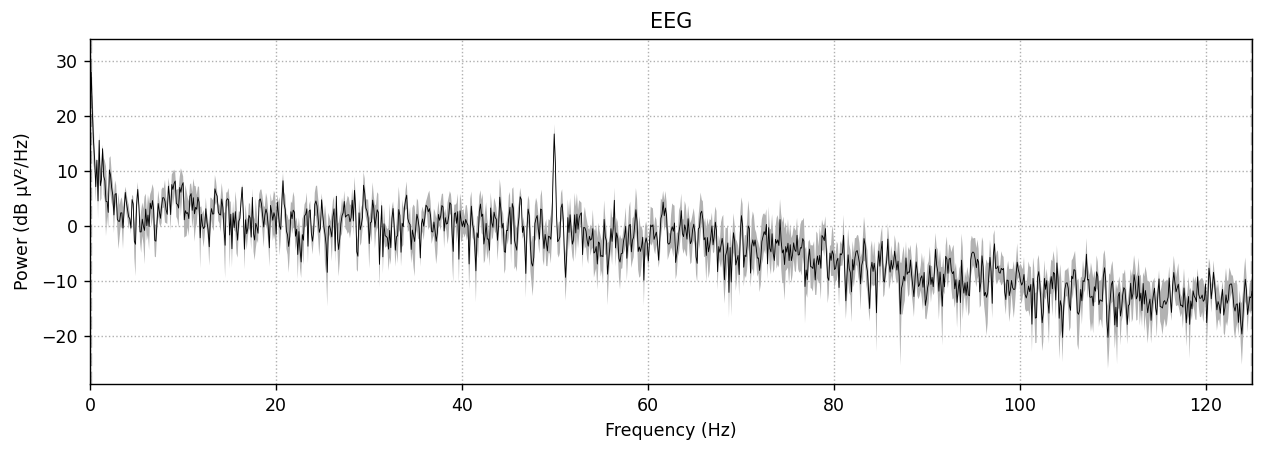

In [164]:
spectrum = raw.compute_psd()
spectrum.plot(average=True, picks="data", exclude="bads", amplitude=False)

In [95]:
# raw.plot(block=True)

In [47]:
# midline = ["EEG 002", "EEG 012", "EEG 030", "EEG 048", "EEG 058", "EEG 060"]
# spectrum.plot(picks="all", exclude="bads", amplitude=False)

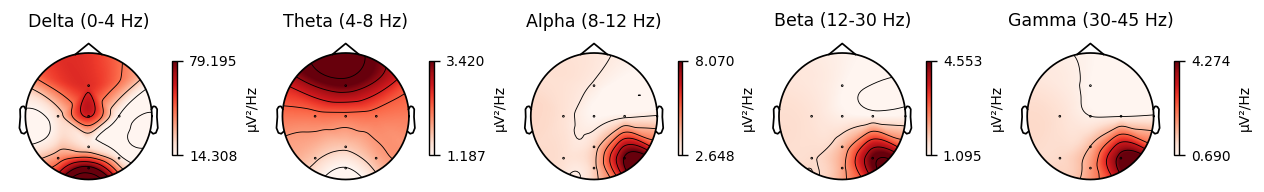

In [165]:
spectrum.plot_topomap()

In [97]:
# spectrum.plot_topo()

In [98]:
# raw.plot_sensors(ch_type="eeg")

In [39]:
# raw.plot_projs_topomap(colorbar=True)

In [166]:
epochs = mne.Epochs(raw, raw_events, raw_events_mapping, tmin=-0.1, tmax=1,
                    baseline=(None, 0), preload=True)

Not setting metadata
12 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 276 original time points ...
1 bad epochs dropped


In [129]:
# epochs['LEFT']

In [167]:
ev_left = epochs['LEFT'].average()
ev_right = epochs['RIGHT'].average()

In [168]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
_ = f.suptitle('Left / Right Imagery', fontsize=20)
_ = ev_left.plot(axes=axs[0], show=True, time_unit='s')
_ = ev_right.plot(axes=axs[1], show=False, time_unit='s')

plt.show()
# plt.tight_layout()

In [169]:
X = epochs.get_data(copy=False)  # Shape: (n_epochs, n_channels, n_times)
y = epochs.events[:, 2]  # Shape: (n_epochs,)

In [172]:
epochs['LEFT'].plot_image(cmap='interactive')
epochs['RIGHT'].plot_image(cmap='interactive')

Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
combining channels using GFP (eeg channels)
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
combining channels using GFP (eeg channels)


[<Figure size 800x600 with 3 Axes>]

In [173]:
# Reshape the data to (n_samples, n_features)
X = X.reshape(len(X), -1)

# Create and train a classifier
clf = make_pipeline(Vectorizer(), RandomForestClassifier(n_estimators=100))
clf.fit(X, y)

Pipeline(steps=[('vectorizer',
                 <mne.decoding.transformer.Vectorizer object at 0x000002BA420959F0>),
                ('randomforestclassifier', RandomForestClassifier())])

In [174]:
test_index = 0  # Use the first training data point for prediction
test_sample = X[test_index].reshape(1, -1)  # Reshape to (1, n_features)
predicted_label = clf.predict(test_sample)
actual_label = y[test_index]
print(f"Predicted label: {predicted_label[0]}, Actual label: {actual_label}")

Predicted label: 1, Actual label: 1


In [57]:
# -----------------------Evoked-----------------------------------------------------------------------------------------

In [30]:
root = mne.datasets.sample.data_path() / "MEG" / "sample"
evoked_file = root / "sample_audvis-ave.fif"
evokeds_list = mne.read_evokeds(
    evoked_file, baseline=(None, 0), proj=True, verbose=False
)

# Show condition names and baseline intervals
for e in evokeds_list:
    print(f"Condition: {e.comment}, baseline: {e.baseline}")
    
conds = ("aud/left", "aud/right", "vis/left", "vis/right")
evks = dict(zip(conds, evokeds_list))

Condition: Left Auditory, baseline: (-0.19979521315838786, 0.0)
Condition: Right Auditory, baseline: (-0.19979521315838786, 0.0)
Condition: Left visual, baseline: (-0.19979521315838786, 0.0)
Condition: Right visual, baseline: (-0.19979521315838786, 0.0)


In [63]:
evoked_file

WindowsPath('C:/Users/iamth/mne_data/MNE-sample-data/MEG/sample/sample_audvis-ave.fif')

In [62]:
evks

{'aud/left': <Evoked | 'Left Auditory' (average, N=55), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 376 ch, ~4.5 MB>,
 'aud/right': <Evoked | 'Right Auditory' (average, N=61), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 376 ch, ~4.5 MB>,
 'vis/left': <Evoked | 'Left visual' (average, N=67), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 376 ch, ~4.5 MB>,
 'vis/right': <Evoked | 'Right visual' (average, N=58), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 376 ch, ~4.5 MB>}

In [ ]:
# ------------------------------------------ Old code

In [11]:
# Perform an as of merge to find the closest earlier and later event_id
df_buffers['prev_event_id'] = pd.merge_asof(df_buffers, df_tasks,
                                            left_on='timestamps', right_on='timestamps',
                                            direction='backward')['event_ids']

df_buffers['next_event_id'] = pd.merge_asof(df_buffers, df_tasks,
                                            left_on='timestamps', right_on='timestamps',
                                            direction='forward')['event_ids']

markers = {
    'left_start': [1],
    'left_end': [2],
    'right_start': [3],
    'right_end': [4],
    'rest_start': [99],
    'rest_end': [100],
    'task_start': [-1],
    'task_end': [-2]
}

def determine_phase(row):
    if row['prev_event_id'] in markers['left_start'] and row['next_event_id'] in markers['left_end']:
        return 'left'
    elif row['prev_event_id'] in markers['right_start'] and row['next_event_id'] in markers['right_end']:
        return 'right'
    elif row['prev_event_id'] in markers['rest_start'] and row['next_event_id'] in markers['rest_end']:
        return 'rest'
    else:
        return 'unknown'

df_buffers['phase'] = df_buffers.apply(determine_phase, axis=1)

grouped = df_buffers.groupby(['part_number', 'phase']).size().reset_index(name='count')

sfreq = config.device_details['sfreq']
buffer_duration = config.epoch_information['duration']

valid_phases = ['left', 'right', 'rest']


In [12]:
df_buffers_filt = df_buffers[df_buffers['phase'].apply(lambda x: any(item in x for item in valid_phases))]

In [13]:
df_buffers_filt.loc[:,'phase_group'] = (df_buffers_filt['phase'] != df_buffers_filt['phase'].shift()).cumsum()

C:\Users\iamth\AppData\Local\Temp\ipykernel_16328\25960297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buffers_filt.loc[:,'phase_group'] = (df_buffers_filt['phase'] != df_buffers_filt['phase'].shift()).cumsum()


In [14]:
df_phase_map = df_buffers_filt[['phase_group', 'phase']].drop_duplicates()

In [15]:
df_buffers_filt

,buffer_col_0,buffer_col_1,buffer_col_2,buffer_col_3,buffer_col_4,buffer_col_5,buffer_col_6,buffer_col_7,buffer_col_8,buffer_col_9,...,buffer_col_13,buffer_col_14,buffer_col_15,buffer_col_16,timestamps,part_number,prev_event_id,next_event_id,phase,phase_group
250,710610.1875,710551.8750,711185.8750,711149.5000,710992.7500,711349.9375,711281.1875,711513.6250,-0.053223,1.001709,...,1.251221,80.0,12909.0,1.0,690721.262570,3,1.0,2.0,left,1
251,710591.0625,710532.1875,711166.1250,711129.6250,710973.6250,711330.4375,711261.0000,711493.9375,-0.052734,0.999023,...,1.007080,80.0,12910.0,1.0,690721.277094,3,1.0,2.0,left,1
252,710589.3750,710530.6250,711165.3750,711128.8125,710972.4375,711328.7500,711260.2500,711493.2500,-0.052002,1.000488,...,0.793457,80.0,12911.0,1.0,690721.277129,3,1.0,2.0,left,1
253,710597.3125,710539.1250,711178.2500,711141.5000,710980.7500,711337.2500,711272.6875,711505.3125,-0.052246,1.001465,...,0.610352,80.0,12912.0,1.0,690721.279426,3,1.0,2.0,left,1
254,710607.4375,710548.9375,711187.1875,711150.5625,710990.5000,711347.3125,711282.0000,711514.6875,-0.054199,1.002441,...,0.366211,80.0,12913.0,1.0,690721.279453,3,1.0,2.0,left,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526,710615.1250,710556.6875,711191.3125,711154.9375,710997.3125,711354.8750,711286.5625,711519.4375,-0.060059,1.001465,...,0.671387,80.0,17310.0,1.0,690738.839527,21,99.0,100.0,rest,10
2527,710602.1250,710543.6875,711178.4375,711142.0625,710984.8750,711342.2500,711273.3125,711506.3125,-0.060547,1.003662,...,0.579834,80.0,17311.0,1.0,690738.847772,21,99.0,100.0,rest,10
2528,710594.0625,710535.5000,711170.7500,711134.4375,710977.0000,711334.0000,711265.8125,711498.6250,-0.061523,1.003906,...,0.579834,80.0,17312.0,1.0,690738.852044,21,99.0,100.0,rest,10
2529,710603.0000,710544.6250,711178.0625,711141.6250,710985.5000,711343.1250,711273.3125,711505.9375,-0.059326,1.002197,...,0.640869,80.0,17313.0,1.0,690738.852054,21,99.0,100.0,rest,10


In [28]:
def get_phase_name(phase_group_number):
    # Look up the phase group number in the DataFrame
    phase_name = df_phase_map.loc[df_phase_map['phase_group'] == phase_group_number, 'phase']
    
    # Check if the phase group number exists in the DataFrame
    if not phase_name.empty:
        return phase_name.values[0]
    else:
        return "Invalid phase group number"

In [29]:
val_sel_columns = config.device_details['relevant_channels_from_device']
columns_to_select = df_buffers.columns[:val_sel_columns].tolist() + ['part_number', 'timestamps', 'phase', 'phase_group']
df_buffers_filt = df_buffers_filt[columns_to_select]

In [30]:

rename_dict = {old_name: new_name for old_name, new_name in zip(df_buffers_filt.columns[:val_sel_columns], channel_names)}
df_buffers_renamed = df_buffers_filt.rename(columns=rename_dict)

In [31]:
df_buffers_renamed[channel_names] = df_buffers_renamed[channel_names].values * 1e-6

In [6]:
df_tasks

,event_ids,timestamps
0,-1,690721.257991
1,1,690721.258034
2,2,690723.789639
3,99,690723.789780
4,100,690724.790197
5,3,690724.790282
6,4,690727.310579
7,99,690727.310641
8,100,690728.310771
9,1,690728.310793


Onsets: [690721.2580341, 690723.7897802, 690724.7902818, 690727.3106413, 690728.3107932, 690730.8274592, 690731.8279824, 690734.3419004, 690735.3421138, 690737.8584416]
Durations: [2.5316049999091774, 1.0004165000282228, 2.5202967000659555, 1.000129499938339, 2.5165763999102637, 1.0004875999875367, 2.513808000017889, 1.0001930999569595, 2.5162627999670804, 1.00055140000768]
Descriptions: ['LEFT', 'REST', 'RIGHT', 'REST', 'LEFT', 'REST', 'RIGHT', 'REST', 'LEFT', 'REST']


In [42]:
df_buffers_renamed

,Fz,C3,Cz,C4,Pz,PO7,Oz,PO8,epoch_number,timestamps,phase,phase_group
250,0.710610,0.710552,0.711186,0.711149,0.710993,0.711350,0.711281,0.711514,3,690721.262570,left,1
251,0.710591,0.710532,0.711166,0.711130,0.710974,0.711330,0.711261,0.711494,3,690721.277094,left,1
252,0.710589,0.710531,0.711165,0.711129,0.710972,0.711329,0.711260,0.711493,3,690721.277129,left,1
253,0.710597,0.710539,0.711178,0.711141,0.710981,0.711337,0.711273,0.711505,3,690721.279426,left,1
254,0.710607,0.710549,0.711187,0.711151,0.710990,0.711347,0.711282,0.711515,3,690721.279453,left,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2526,0.710615,0.710557,0.711191,0.711155,0.710997,0.711355,0.711287,0.711519,21,690738.839527,rest,10
2527,0.710602,0.710544,0.711178,0.711142,0.710985,0.711342,0.711273,0.711506,21,690738.847772,rest,10
2528,0.710594,0.710535,0.711171,0.711134,0.710977,0.711334,0.711266,0.711499,21,690738.852044,rest,10
2529,0.710603,0.710545,0.711178,0.711142,0.710985,0.711343,0.711273,0.711506,21,690738.852054,rest,10


<Annotations | 11 segments: LEFT (3), REST (5), RIGHT (2), TASK (1)>


In [ ]:
df_buffers_renamed

In [ ]:
# Creating epochs data
epochs_data = []
events = []

event_id = {'left': 1, 'right': 2, 'rest': 3}
phases = ['left', 'right', 'rest']

In [ ]:
max_shape = 0  # Initialize maximum shape

for i, df_phase_group in df_buffers_renamed.groupby('phase_group'):
    if get_phase_name(i) not in phases:
        continue
    data_array = df_phase_group[channel_names].values.T
    max_shape = max(max_shape, data_array.shape[1])
    epochs_data.append(data_array)
    
    phase_group = df_phase_group['phase_group'].iloc[0]
    phase = df_phase_map[df_phase_map['phase_group'] == phase_group]['phase'].iloc[0]
    event = event_id[phase]
    
    events.append([len(epochs_data) - 1, 0, event])

In [ ]:
events = np.array(events)

In [ ]:
events

In [ ]:
# Pad or truncate each epoch's data to match the maximum shape
for i, data_array in enumerate(epochs_data):
    current_shape = data_array.shape[1]
    if current_shape < max_shape:
        padding = ((0, 0), (0, max_shape - current_shape))
        epochs_data[i] = np.pad(data_array, padding, mode='constant')
    elif current_shape > max_shape:
        epochs_data[i] = data_array[:, :max_shape]

# Convert epoch_data to numpy array
epochs_data = np.array(epochs_data)

# Print the shape of epoch_data
print("Shape of epoch_data:", epochs_data.shape)

In [ ]:
# Create MNE info structure
info = create_info(ch_names=channel_names, sfreq=config.device_details['sfreq'], ch_types='eeg')

# Create MNE Epochs object
epochs = EpochsArray(epochs_data, info, events, event_id=event_id, tmin=0)




In [ ]:
# X
# y



In [ ]:
# epochs.get_data()[8]
# epochs[2].plot(n_channels=8, picks=['eeg'])


# epochs.plot_topo_image()

In [ ]:
y

In [ ]:
# X